Vou aplicar a ideia desse artigo, onde o autor cria uma estratégia vencedora para os Dardos usando redes neurais com um função de custo customatizada, para o Tênis:[https://medium.com/vantageai/beating-the-bookies-with-machine-learning-7b429a0b5980](https://medium.com/vantageai/beating-the-bookies-with-machine-learning-7b429a0b5980)

Como o artigo acima diz há duas formas de você bater as casas de apostas:
* Se você estima as probabilidades sempre que melhor as casas, por uma margem tal que você compensa a margem de lucro que elas embutiram nas odds. 
* Se você apostar apenas nos jogos que a casa cometeu um erro e as odds estão a seu favor


Vamos carregar o nosso DataFrame com os dados do arquivo csv com os dados da página [http://tennis-data.co.uk/data.php](http://tennis-data.co.uk/data.php). São dados frequentemene utilizados por serem de gratuitos, de fácil acesso e de uma longa série histórica 2000 até os dias atuais. Mas optei pelos jogos apatir do ano de 2005, visto que apartir desse ano os WPts	e LPts passaram a serem preenchidos.

No código seguinte vamos ler o CSV, formatar a data remover os jogos com infomações faltantes



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

#Lê o arquivo CSV 
df=pd.read_csv('../input/ATP_matches_tennis-data.co.uk.csv',low_memory=False)

#Lê a data do formatp m/d/Y para o formato Y-m-d
df.Date = df.Date.apply(lambda x:datetime.strptime(x, '%m/%d/%Y')) 

#Remove as linhas que não possuam preenchidos os campos WPts, B365W, PSW
df= df[df.B365W.notnull() &  df.PSW.notnull()]   

df

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,WPts,LPts,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,B365W,B365L,PSW,PSL
0,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Saulnier C.,Baccanello P.,53.0,324.0,NaN,NaN,6.0,2.0,7,6,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,1.286,3.250,1.305,3.780
1,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,Sluiter R.,72.0,82.0,NaN,NaN,6.0,3.0,6,1,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,1.833,1.833,1.990,1.840
2,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Melzer J.,Berdych T.,39.0,45.0,NaN,NaN,6.0,4.0,4,6,7,6,NaN,NaN,NaN,NaN,2.0,1,Completed,1.800,1.909,1.901,1.917
3,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Rochus O.,Dupuis A.,66.0,79.0,NaN,NaN,6.0,3.0,3,6,6,1,NaN,NaN,NaN,NaN,2.0,1,Completed,1.667,2.100,1.621,2.410
4,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Mayer F.,Arthurs W.,35.0,101.0,NaN,NaN,6.0,4.0,3,6,7,5,NaN,NaN,NaN,NaN,2.0,1,Completed,1.615,2.200,1.787,2.070
5,1,Adelaide,Next Generation Hardcourts,2005-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.,Schalken S.,21.0,57.0,NaN,NaN,6.0,2.0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,Retired,1.333,3.000,1.408,3.100
6,1,Adelaide,Next Generation Hardcourts,2005-01-04,International,Outdoor,Hard,1st Round,3,Malisse X.,Martin A.,48.0,68.0,NaN,NaN,6.0,2.0,7,6,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,1.500,2.500,1.575,2.540
7,1,Adelaide,Next Generation Hardcourts,2005-01-04,International,Outdoor,Hard,1st Round,3,Benneteau J.,Starace P.,65.0,76.0,NaN,NaN,6.0,3.0,6,4,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,1.533,2.375,1.549,2.620
8,1,Adelaide,Next Generation Hardcourts,2005-01-04,International,Outdoor,Hard,1st Round,3,Stepanek R.,Kohlschreiber P.,33.0,88.0,NaN,NaN,6.0,3.0,6,4,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,1.400,2.750,1.435,3.000
9,1,Adelaide,Next Generation Hardcourts,2005-01-04,International,Outdoor,Hard,1st Round,3,Dent T.,Ginepri R.,32.0,63.0,NaN,NaN,6.0,1.0,2,6,6,2,NaN,NaN,NaN,NaN,2.0,1,Completed,1.667,2.100,1.719,2.190


Nesse DataFrame anterior várias colunas têm como refêrencia o Vencedor(Winner) e o Perdedor(Loser), creio que é mais simples ter como referência Jogador1 e Jogador2, que podem ser o Favorito(Favorite) e o Azarão(Underdog). Então vamos criar um novo DataFrame df2 com apenas com as colunas que vamos utilizar no nosso modelo alterando as colunas para que o favorito que seja o J1 e o azarão seja o J2, vamos usar como base o as odds da Pinnacle, que serão as usadas para verificar a lucratividade da estratégia. Ou seja:
* J1 é o favorito
* J2 é o azarão

In [2]:
df2=pd.DataFrame(columns=['Best_of_5','J1_B365','J2_B365','J1_PS','J2_PS','J1_W'])

# 1 se é melhor de 5 sets senão 0  
df2.Best_of_5 = np.where(df['Best of']==5, 1, 0)  

df2.J1_B365 = np.where(df.PSW<df.PSL, df.B365W, df.B365L) #Odds Bet365 para J1 vencer
df2.J2_B365 = np.where(df.PSW>df.PSL, df.B365W, df.B365L) #Odds Bet365 para J2 vencer

df2.J1_PS = np.where(df.PSW<df.PSL, df.PSW, df.PSL) #Odds Pinnacle para J1 vencer
df2.J2_PS = np.where(df.PSW>df.PSL, df.PSW, df.PSL) #Odds Pinnacle para J2 vencer


# 1 se J1 venceu, 0 se J2 venceu
df2.J1_W = np.where(df.PSW<df.PSL, 1, 0) 

#df2.pl1 = np.where(df.PSW<df.PSL, df2.J1_PS, 0)-1



df2

,Best_of_5,J1_B365,J2_B365,J1_PS,J2_PS,J1_W
0,0,1.286,3.250,1.305,3.780,1
1,0,1.833,1.833,1.840,1.990,0
2,0,1.800,1.909,1.901,1.917,1
3,0,1.667,2.100,1.621,2.410,1
4,0,1.615,2.200,1.787,2.070,1
5,0,1.333,3.000,1.408,3.100,1
6,0,1.500,2.500,1.575,2.540,1
7,0,1.533,2.375,1.549,2.620,1
8,0,1.400,2.750,1.435,3.000,1
9,0,1.667,2.100,1.719,2.190,1


Segue uma simulação do ROI médio se tivessemos apostados em todos os Favoritos e em todos Underdogs nas duas casas que temos as odds. De longe, a nossa desvantagem é menor se nos concentrarmos em realizar nos favoritos na Pinnacle.

{'Pinnacle_Favorito': -0.02093697083725306, 'Pinnacle_Underdog': -0.04752327603409449, 'Bet365_Favorito': -0.057361982952763756, 'Bet365_Underdog': -0.1132942216140711}


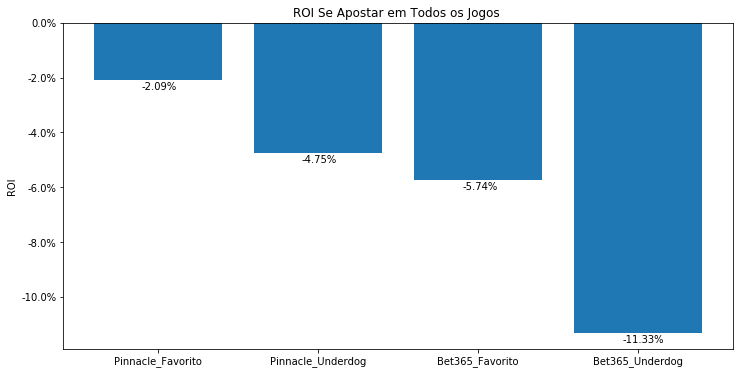

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

medias={
    'Pinnacle_Favorito': np.where(df2.J1_W==1, df2.J1_PS-1, -1).mean(),
    'Pinnacle_Underdog': np.where(df2.J1_W==0, df2.J2_PS-1, -1).mean(),
    'Bet365_Favorito': np.where(df2.J1_W==1, df2.J1_B365-1, -1).mean(),
    'Bet365_Underdog': np.where(df2.J1_W==0, df2.J2_B365-1, -1).mean()
}

print(medias)


labels = [e for e in medias]
rois = [medias[e]*100 for e in medias]

index = np.arange(len(labels))

plt.figure(figsize=(12,6))
plt.bar(index, rois)
plt.ylabel('ROI')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.xticks(index, labels, fontsize=10, rotation=0)
plt.title('ROI Se Apostar em Todos os Jogos ')
for i in range(len(rois)): plt.text(i-0.1, rois[i]-0.35, "{0:.2%}".format(rois[i]/100) ) 
plt.show()


Quando trabalhando com Redes Neurais é sempre bom ter dados bem comportados, que estejam todos na mesma magnitude. Vamos então normalizar esse dataframe deixando todas as colunas na escala entre 0 e 1. 

Para as odds basta tomar o inverso.

Os demais campos já estão entre 0 e 1, então não seja necessário alterar

In [4]:
#Para cada coluna de odds tomamos o inverso
for coluna in ['J1_B365','J2_B365','J1_PS','J2_PS']: 
    df2[coluna]=1/df2[coluna]

#Exporta o DataFrame 
df2.to_csv('df2.csv')
    
df2


,Best_of_5,J1_B365,J2_B365,J1_PS,J2_PS,J1_W
0,0,0.777605,0.307692,0.766284,0.264550,1
1,0,0.545554,0.545554,0.543478,0.502513,0
2,0,0.555556,0.523834,0.526039,0.521648,1
3,0,0.599880,0.476190,0.616903,0.414938,1
4,0,0.619195,0.454545,0.559597,0.483092,1
5,0,0.750188,0.333333,0.710227,0.322581,1
6,0,0.666667,0.400000,0.634921,0.393701,1
7,0,0.652316,0.421053,0.645578,0.381679,1
8,0,0.714286,0.363636,0.696864,0.333333,1
9,0,0.599880,0.476190,0.581734,0.456621,1


Agora diviremos o DataFrame em dois: 75% treinamento e 25% teste, 

In [5]:
df_train=df2[:int(len(df2)*0.75)]
df_test=df2[int(len(df2)*0.75):]

print('Qtd de Registos')
print('train:', len(df_train) )
print('test : ', len(df_test) )

Qtd de Registos
train: 26309
test :  8770


Nesse modelo, será usado o [PyTorch](https://pytorch.org/) que é o framework de Machine Learning em Python, mais [*pythônico*](https://pt.stackoverflow.com/questions/192343/o-que-%C3%A9-c%C3%B3digo-pyth%C3%B4nico/192347#192347) que conheço. 

Nas linhas seguintes será criado o modelo e otimizador do modelo baseado nos dados

In [6]:
import torch
from torch.nn import Linear,Sigmoid,Sequential,CrossEntropyLoss, ReLU, Tanh
from torch import sum as sum_
from torch.nn.functional import relu as relu_

from torch import optim

#Tamanho da amostra aletória que será usada do treinamento de cada vez
batch_size=500

#D_in é a dimensão do nossos inputs X, a quantidade de atributos 
D_in=df_train.columns.size

#D_h é da camada oculta
D_h=10

#D_out é a dimensão da nossa saída Y, que será 1, apenas uma váriavel, a probabilidade de J1 vencer
D_out=1

#Definimos um modelo linear com apenas 2 camadas, entrada e saída, depois seguirá para um Sigmoid para retornar valores entre 0 e 1  
modelo=Sequential(Linear(D_in,D_out) )


#Inicia os parametros
with torch.no_grad():
    for param in modelo.parameters(): param.uniform_(0,1)


#Definimos otimizador no nosso modelo, com taxa de aprendizagem 0.001
otimizador=optim.Adam(modelo.parameters(), lr=0.001)


#Essa é função de custo, que o "Pulo do Gato", quanto menor maior será lucrativa sa estratégia
def customLoss(Y,Y_pred,O1,O2):
    return -sum_( (O1*Y-1)*relu_(O1*Y_pred-1)+ (O2*(1-Y)-1)*relu_(O2*(1-Y_pred)-1)   )
#def customLoss(PL,Y_pred):
#    return -sum_(PL*Y_pred   )    


Agora será criado loop de treino em cada intereção, nosso modelo deve ficar melhor. Isso signifca cada vez mais lucrativo. 

Assim como no artigo, vamos usar a Função Custo Customizada como na figura abaixo. Que é o "Pulo do Gato". Mas vamos apenas apostar no Jogador1, o Favorito, pois vimos que é nesse que nossa desvantagem é menor.

<img src="https://cdn-images-1.medium.com/max/500/1*VxBBSuKO-ZJK3ArTps2rmQ.jpeg">

In [7]:
pl=0
stake=0

loss_total=0
#Loop de treino, em cada interessaram mais treinado e preciso deverá ficar nosso modelo
for i in range(5000+1):
    
    #Seleciona um amostra aleatória do treinamento
    df_sample=df_train.sample(batch_size)
    
    #Cria o tensor X com os inputs do modelo serão todas as colunas exceto J1_W 
    #X=torch.from_numpy(df_sample.loc[:,(df_sample.columns!='J1_W') ].values).float()
    X=torch.from_numpy(df_sample.loc[:,(df_sample.columns!='pl1') ].values).float()
    
    
    #Cria o tensor Y com target do modelo a vitória ou derrota do favorito J1_W 
    Y=torch.from_numpy(df_sample['J1_W'].values).float()
    #Y=torch.from_numpy(df_sample['pl1'].values).float()
    
    #Cria os tensores O1 e O2 com as odds da Pinnacle para J1 e J2, será usado para verificar a lucratividade
    O1=1/torch.from_numpy(df_sample['J1_PS'].values).float()
    O2=1/torch.from_numpy(df_sample['J2_PS'].values).float()
    

    #Y previstos pelo modelo, serão as probabilidades previstas para J1 vencer
    Y_pred=modelo(X)

    #Função custo customizada que tenta maximizar a lucratividade
    loss=customLoss(Y,Y_pred,O1,O2)
    #loss=customLoss(PL,Y_pred)
    
    # Backward pass
    loss.backward()
    otimizador.step()        
    otimizador.zero_grad()
    
    

        
    with torch.no_grad():
        #pl+=( PL*Y_pred ).sum().item()
        #stake+=( Y_pred  ).sum().item()
        pl+=( (O1*Y-1)*relu_(O1*Y_pred-1) + (O2*(1-Y)-1)*relu_(O2*(1-Y_pred)-1)    ).sum().item()
        stake+=(relu_(O1*Y_pred-1)  + relu_(O2*(1-Y_pred)-1)  ).sum().item()
        #Cada 100 interações mostra a lucratividade da estratégia
        if i%100==0:
            if i==0: 
                print('Interação      ROI' )
            else:
                print(i,'         ',"{0:.2%}".format(pl/stake))    
            pl=0
            stake=0
        
  


Interação      ROI
100           -1.69%
200           -2.63%
300           -1.68%
400           -1.68%
500           -2.62%
600           -2.40%
700           -2.62%
800           -2.87%
900           -2.91%
1000           -2.70%
1100           -2.74%
1200           -2.12%
1300           -1.83%
1400           -2.20%
1500           -2.70%
1600           -3.01%
1700           -2.56%
1800           -2.21%
1900           -1.97%
2000           -3.09%
2100           -2.83%
2200           -2.36%
2300           -2.62%
2400           -3.40%
2500           -2.49%
2600           -2.70%
2700           -1.96%
2800           -3.02%
2900           -2.47%
3000           -2.38%
3100           -2.76%
3200           -2.53%
3300           -2.67%
3400           -2.55%
3500           -1.88%
3600           -2.27%
3700           -2.48%
3800           -2.80%
3900           -2.72%
4000           -2.61%
4100           -2.77%
4200           -2.70%
4300           -2.24%
4400           -2.13%
4500           -2.93%


Nosso modelo com não se mostrou melhor que a estratégia de apostar em todos os favoritos. Na verdade foi bem pior. Vou tentantar uma nova abordagem em outro notebook